In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import datetime

# Load Dataset

In [269]:
data = pd.read_csv("data/005930.KS.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-25,23440.0,23520.0,23120.0,23240.0,1116.319580,7995650.0
1,2016-01-26,23100.0,23140.0,22720.0,22740.0,1092.302368,7619950.0
2,2016-01-27,22520.0,23500.0,22520.0,23500.0,1128.808350,13811850.0
3,2016-01-28,23280.0,23360.0,22780.0,22900.0,1099.987793,15795600.0
4,2016-01-29,22800.0,23000.0,22320.0,23000.0,1104.791382,21849150.0


In [301]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1220,2021-01-18,86600.0,87300.0,84100.0,85000.0,85000.0,43227951.0
1221,2021-01-19,84500.0,88000.0,83600.0,87000.0,87000.0,39895044.0
1222,2021-01-20,89000.0,89000.0,86500.0,87200.0,87200.0,25211127.0
1223,2021-01-21,87500.0,88600.0,86500.0,88100.0,88100.0,25318011.0
1224,2021-01-22,89000.0,89700.0,86800.0,86800.0,86800.0,30861661.0


# Compute Mid price

In [270]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows

In [292]:
# recent 50 days - window size
seq_len = 50
# window size + 1(for prediction)
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data

In [293]:
normalized_data = []
for window in result:
    # devide all data in windows by the first data and minus 1
    # to set the first value 0
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# Split train and test data
# use 90% of data as train
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

# put 50 obs in x_train
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# put 1 obs in y_train
y_train = train[:, -1]

# test is the same as train
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

# Build a Model

In [294]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [295]:
x_train = pd.DataFrame(x_train.squeeze(2)).fillna(0.0).values.reshape((x_train.shape[0], x_train.shape[1], 1))

In [296]:
y_train = pd.DataFrame(y_train).fillna(0.0).values

In [299]:
model.fit(x_train, y_train,
         validation_data = (x_test, y_test),
         batch_size = 10,
         epochs = 20)

Epoch 1/20
106/106 [==============================] - 6s 32ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 2/20
106/106 [==============================] - 2s 17ms/step - loss: 9.9241e-04 - val_loss: 0.0020
Epoch 3/20
106/106 [==============================] - 2s 20ms/step - loss: 7.2910e-04 - val_loss: 0.0056
Epoch 4/20
106/106 [==============================] - 2s 21ms/step - loss: 7.6588e-04 - val_loss: 0.0013
Epoch 5/20
106/106 [==============================] - 2s 19ms/step - loss: 6.2692e-04 - val_loss: 7.0784e-04
Epoch 6/20
106/106 [==============================] - 2s 21ms/step - loss: 8.7493e-04 - val_loss: 0.0010
Epoch 7/20
106/106 [==============================] - 2s 22ms/step - loss: 5.7604e-04 - val_loss: 7.2970e-04
Epoch 8/20
106/106 [==============================] - 2s 19ms/step - loss: 4.6574e-04 - val_loss: 4.9901e-04
Epoch 9/20
106/106 [==============================] - 2s 22ms/step - loss: 4.7597e-04 - val_loss: 6.1622e-04
Epoch 10/20
106/106 [======================

# Prediction

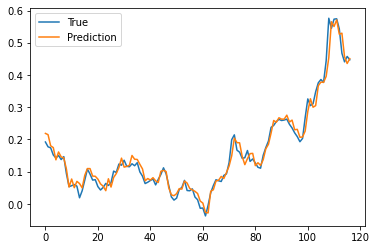

In [300]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()